In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler,  LabelEncoder, OneHotEncoder

from torch import Tensor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pre-processing Data

In [86]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')

In [87]:
df['acc_ratio'] = df['acc_now_delinq'] / df['open_acc']

In [88]:
df = df.drop(columns=['delinq_amnt', 'out_prncp_inv', 'acc_now_delinq', 'funded_amnt_inv'])

In [89]:
df['my_multiple'] = df['int_rate']*df['dti']
df['my_multiple2'] = np.log(df['annual_inc']*df['fico_range_low'])
df['my_multiple4'] = df['int_rate']*df['funded_amnt']
df['my_multiple5'] = df['int_rate']*df['dti']/np.log(df['tot_cur_bal']*df['fico_range_low'])
df['my_multiple6'] = df['revol_util']/(df['revol_bal']+0.0000001)
df['my_multiple7'] = df['int_rate']*df['funded_amnt']/np.log(df['tot_cur_bal']*df['fico_range_low']+2)
df['my_multiple9'] = np.log(df['int_rate']*df['funded_amnt'])*df['dti']
df['my_multiple11'] = df['installment']/ df['annual_inc']
df.loc[df['collections_12_mths_ex_med'] <= 0.1, 'collections_12_mths_ex_med'] = 0   # 0번 추심 발생횟수
df.loc[df['collections_12_mths_ex_med']  > 0.1, 'collections_12_mths_ex_med'] = 1   # 1번 이상 추심 발생횟수
df['my_clf2'] = df.groupby([df.term1, df.emp_length12, df.home_ownership6, df.verification_status3, df.initial_list_status1, df.collections_12_mths_ex_med, df.initial_list_status2])['depvar'].transform('mean')

In [90]:
df_proc = df.copy()

In [91]:
df_proc.loc[df_proc['tot_cur_bal']>1200000, 'tot_cur_bal'] = 1200000
df_proc.loc[df_proc['annual_inc']>480000, 'annual_inc'] = 480000
df_proc.loc[df_proc['revol_bal']>290000, 'revol_bal'] = 290000
df_proc.loc[df_proc['revol_util']>1.785, 'revol_util'] = 1.785
df_proc.loc[df_proc['total_rec_late_fee']>53, 'total_rec_late_fee'] = 53
df_proc.loc[df_proc['total_acc']>89, 'total_acc'] = 89
df_proc.loc[df_proc['open_acc']>41, 'open_acc'] = 41
df_proc.loc[df_proc['tot_coll_amt']>0.00008, 'tot_coll_amt'] = 0.00008

In [8]:
# 구간으로 축약하기 (13개) // aux(auxiliary) = 보조의
auxtotal_rec_int = pd.cut(df_proc['total_rec_int'], 6) 
auxint_rate = pd.cut(df_proc['int_rate'], 15)      # 뒤쪽일수록 1비율 큼. 의미O
auxinstallment = pd.cut(df_proc['installment'], 15)  #특징 X
auxtot_cur_bal = pd.cut(df_proc['tot_cur_bal'], 10)  #뒤쪽으로 갈수록 1비율 낮음
auxdti = pd.cut(df_proc['dti'], 10)                # 뒤쪽으로 갈수록 0비율 높음 의미O
auxannual_inc = pd.cut(df_proc['annual_inc'], 10)  # 처음 1구간에 몰려있음
auxrevol_bal = pd.cut(df_proc['revol_bal'], 10)    # 처음 2구간에 몰려있음
auxrevol_util = pd.cut(df_proc['revol_util'], 10)  # 처음 2구간에 몰려있음
auxtotal_acc = pd.cut(df_proc['total_acc'], 10)    #특징 X
auxopen_acc = pd.cut(df_proc['open_acc'], 10)      #특징 X
auxfico_range_low = pd.cut(df_proc['fico_range_low'], 10)  #앞쪽일수록 1비율 큼. 의미O
auxfico_range_high = pd.cut(df_proc['fico_range_high'], 10)  #앞쪽일수록 1비율 큼. 의미O
auxfunded_amnt = pd.cut(df_proc['funded_amnt'], 10)  #앞쪽일 수록 0이 살짝 큰것같은데 미미함.

# aux_list 13개
aux_dict = {'total_rec_int':auxtotal_rec_int, 'int_rate':auxint_rate, 'installment':auxinstallment, 
            'tot_cur_bal':auxtot_cur_bal, 'dti':auxdti, 'annual_inc':auxannual_inc, 'revol_bal':auxrevol_bal, 'revol_util':auxrevol_util,
            'total_acc':auxtotal_acc, 'open_acc': auxopen_acc, 'fico_range_low':auxfico_range_low,
            'fico_range_high':auxfico_range_high, 'funded_amnt':auxfunded_amnt}

In [9]:
# df_proc_2 부터는 구간 라벨링 시작
df_proc_2 = df_proc.copy()

In [10]:
# Label넣어줄 리스트 생성
col_for_label = ['total_rec_int', 'int_rate',  'installment', 'tot_cur_bal',
                 'dti', 'annual_inc', 'revol_bal', 'revol_util', 'total_acc', 'open_acc', 'fico_range_low', 'fico_range_high', 'funded_amnt']

# name이 string타입이라 그냥 넣어주면 됨
for name in col_for_label:
    df_proc_2[name] = LabelEncoder().fit_transform(aux_dict[name])

In [11]:
#수동으로 구간 작업한 것 넣어주기

# 코드 순서주의!!!!
df_proc_2.loc[(df_proc_2['total_rec_late_fee'] > 1.7) & (df_proc_2['total_rec_late_fee'] <= 12), 'total_rec_late_fee'] = 4
df_proc_2.loc[df_proc_2['total_rec_late_fee']  > 12, 'total_rec_late_fee'] = 5
df_proc_2.loc[(df_proc_2['total_rec_late_fee'] > 0.06) & (df_proc_2['total_rec_late_fee'] <= 1.7), 'total_rec_late_fee'] = 3
df_proc_2.loc[(df_proc_2['total_rec_late_fee'] > 0.002) & (df_proc_2['total_rec_late_fee'] <= 0.06), 'total_rec_late_fee'] = 2
df_proc_2.loc[(df_proc_2['total_rec_late_fee'] > 0.000001) & (df_proc_2['total_rec_late_fee'] <= 0.002), 'total_rec_late_fee'] = 1
df_proc_2.loc[ df_proc_2['total_rec_late_fee'] <= 0.000001, 'total_rec_late_fee'] = 0

df_proc_2.loc[df_proc_2['tot_coll_amt']  > 0.02, 'tot_coll_amt'] = 2
df_proc_2.loc[(df_proc_2['tot_coll_amt'] > 0.00001) & (df_proc_2['tot_coll_amt'] <= 0.02), 'tot_coll_amt'] = 1
df_proc_2.loc[df_proc_2['tot_coll_amt'] <= 0.00001, 'tot_coll_amt'] = 0

df_proc_2.loc[df_proc_2['delinq_2yrs'] <= 4, 'delinq_2yrs'] = 0                                     #4년이하 2:1 비율
df_proc_2.loc[(df_proc_2['delinq_2yrs'] > 4) & (df_proc_2['delinq_2yrs'] <= 10), 'delinq_2yrs'] = 1 #5~8년 채무불이행비율 증가
df_proc_2.loc[df_proc_2['delinq_2yrs']  > 10, 'delinq_2yrs'] = 2                                    #9년 이상

df_proc_2.loc[df_proc_2['collections_12_mths_ex_med'] <= 0.1, 'collections_12_mths_ex_med'] = 0     # 0번 추심 발생횟수
df_proc_2.loc[df_proc_2['collections_12_mths_ex_med']  > 0.1, 'collections_12_mths_ex_med'] = 1     # 1번 이상

df_proc_2.loc[df_proc_2['tax_liens'] <= 0.1, 'tax_liens'] = 0                                   #0번 세금 저당권 2:1 비율
df_proc_2.loc[(df_proc_2['tax_liens'] > 0.1) & (df_proc_2['tax_liens'] <= 1.5), 'tax_liens'] = 1 #1번 채무불이행비율 증가
df_proc_2.loc[df_proc_2['tax_liens']  > 1.5, 'tax_liens'] = 2 

df_proc_2.loc[df_proc_2['pub_rec'] <= 0.1, 'pub_rec'] = 0                                   #파산 횟수 0번
df_proc_2.loc[(df_proc_2['pub_rec'] > 0.1) & (df_proc_2['pub_rec'] <= 4.2), 'pub_rec'] = 1  #1~4번
df_proc_2.loc[df_proc_2['pub_rec']  > 4.2, 'pub_rec'] = 2                                   #5회 이상

# 코드 넣는 순서 중요!! 거꾸로 하면 0.35 이상은 다 5로 바꿔버림
df_proc_2.loc[df_proc_2['acc_ratio']  > 0.35, 'acc_ratio'] = 5
df_proc_2.loc[(df_proc_2['acc_ratio'] > 0.15) & (df_proc_2['acc_ratio'] <= 0.35), 'acc_ratio'] = 4
df_proc_2.loc[(df_proc_2['acc_ratio'] > 0.05) & (df_proc_2['acc_ratio'] <= 0.15), 'acc_ratio'] = 3
df_proc_2.loc[(df_proc_2['acc_ratio'] > 0.035) & (df_proc_2['acc_ratio'] <= 0.05), 'acc_ratio'] = 2
df_proc_2.loc[(df_proc_2['acc_ratio'] > 0.0001) & (df_proc_2['acc_ratio'] <= 0.035), 'acc_ratio'] = 1
df_proc_2.loc[df_proc_2['acc_ratio'] <= 0.0001, 'acc_ratio'] = 0 

In [ ]:
col_for_dummies = list(df_proc_2.columns)
col_for_dummies.remove('my_multiple')
col_for_dummies.remove('my_multiple2')
col_for_dummies.remove('my_multiple4')
col_for_dummies.remove('my_multiple5')
col_for_dummies.remove('my_multiple6')
col_for_dummies.remove('my_multiple7')
col_for_dummies.remove('my_multiple9')
col_for_dummies.remove('my_multiple11')
col_for_dummies.remove('my_clf2')
col_for_dummies.remove('out_prncp')
col_for_dummies.remove('depvar')


col_for_dummies

In [13]:
df_proc_2.nunique()

int_rate              15
annual_inc            10
dti                   10
delinq_2yrs            3
inq_last_6mths         7
                   ...  
my_multiple6       98923
my_multiple7      100000
my_multiple9       99395
my_multiple11      80017
my_clf2               55
Length: 82, dtype: int64

In [15]:
# df_proc_3 = 원핫인코딩으로 바꿔줌
df_proc_3 = pd.get_dummies(df_proc_2, columns=col_for_dummies)

In [16]:
df_proc_3['depvar'] = df_proc_2['depvar']

In [150]:
# 원핫인코딩안한거
# Train, Valid split
X = df_proc.drop('depvar', axis=1)
y = df_proc['depvar']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.001)
X_train_names = X_train.columns

In [58]:
# Train, Valid split
X = df_proc_3.drop('depvar', axis=1)
y = df_proc_3['depvar']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
X_train_names = X_train.columns

In [93]:
X.shape

(100000, 81)

In [151]:
X_train_sc = StandardScaler().fit_transform(X_train)
X_valid_sc = StandardScaler().fit_transform(X_valid)

In [152]:
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [153]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class ValidData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

train_data = TrainData(torch.FloatTensor(X_train_sc), torch.FloatTensor(y_train.to_numpy()))
valid_data = ValidData(torch.FloatTensor(X_valid_sc), torch.FloatTensor(y_valid.to_numpy()))
# X_test_sc = StandardScaler().fit_transform(X_test)
# test_data = TestData(torch.FloatTensor(X_test_sc))
# y_train과 y_valid는 pandas.Series타입이라서 그대로 Tensor에 넣으면 에러발생함. numpy로 바꿔주고 진행

In [211]:
EPOCHS = 100
BATCH_SIZE = 1012
LEARNING_RATE = 0.001

# data loader 세팅
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=1)

In [212]:
X.shape

(100000, 81)

In [ ]:
# class BinaryClassification(nn.Module):
#     def __init__(self):
#         super(BinaryClassification, self).__init__()
#         self.conv0 = nn.Conv1d(in_channels = 1,
#                                out_channels = 20,
#                                kernel_size = 5,
#                                stride = (1,))
#         self.conv0_bn = nn.LayerNorm([20,1,77])
#         self.conv1 = nn.Conv1d(in_channels = 20,
#                                out_channels = 50,
#                                kernel_size = (1,10),
#                                stride = (1,)) # Layer 2
#         self.conv1_bn = nn.LayerNorm([50,1,68])
#         self.fc1 = nn.Linear(68*50, 200)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(200, 10)

# def forward(self, x):
#         x = self.conv0(x)
#         x = self.conv0_bn(x)
#         x = nn.ReLU(x)

#         x = self.conv1(x)
#         x = self.conv1_bn(x)
#         x = nn.ReLU(x)

#         x = x.view(x.shape[0], -1)
#         x = self.fc1(x)

#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

In [213]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 16
        self.layer_1 = nn.Linear(81, 60) 
        self.layer_2 = nn.Linear(60, 40)
        self.Layer_3 = nn.Sequential(
                                nn.Linear(40, 10),
                                nn.ReLU()
                            )
        self.layer_out = nn.Linear(10, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(60)
        self.batchnorm2 = nn.BatchNorm1d(40)
        self.batchnorm3 = nn.BatchNorm1d(10)

        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.Layer_3(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [204]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 16
        self.conv1 = nn.Conv1d(1, 128, kernel_size=3)   # b, 128, 79
        self.conv1_bn = nn.LayerNorm([128,1,79])

        self.conv2 = nn.Conv1d(128, 50, kernel_size=5, stride=3) # b, 50, 75
        self.conv2_bn = nn.LayerNorm([50,1,26])

        self.fc1 = nn.Linear(50*26, 100)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(100, 2)
        self.batchnorm1 = nn.BatchNorm1d(81)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = inputs.unsqueeze(1)
        print('통과 squeeze')
        x = self.conv1(inputs)
        print('conv1통과')
        x = self.conv1_bn(x)
        x = nn.ReLU(x)
        print('통과conv1')
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = nn.ReLU(x)
        print('통과conv2')
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        print('통과 fc1')
        x = self.dropout(x)
        x = self.fc2(x)
        print('통과 fc2')
        return x

In [178]:
# torch.cuda.device_count() #gpu 갯수
print(device) #cuda 만 있을 때 default로 0번 gpu 배정됨. cuda:0 이랑 같은 것

cuda


In [214]:
# 모델 객체 생성
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=81, out_features=60, bias=True)
  (layer_2): Linear(in_features=60, out_features=40, bias=True)
  (Layer_3): Sequential(
    (0): Linear(in_features=40, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm1): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [215]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [216]:
# Training
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    if e % 10 == 0:
      print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 010: | Loss: 0.49237 | Acc: 75.929
Epoch 020: | Loss: 0.47433 | Acc: 76.717
Epoch 030: | Loss: 0.46537 | Acc: 77.323
Epoch 040: | Loss: 0.45753 | Acc: 77.626
Epoch 050: | Loss: 0.45287 | Acc: 77.909
Epoch 060: | Loss: 0.44808 | Acc: 78.172
Epoch 070: | Loss: 0.44542 | Acc: 78.232
Epoch 080: | Loss: 0.44276 | Acc: 78.444
Epoch 090: | Loss: 0.44087 | Acc: 78.495
Epoch 100: | Loss: 0.43879 | Acc: 78.596


In [217]:
# Validation 
y_pred_array = np.array([])
# y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch, _ in valid_loader:
        X_batch = X_batch.to(device)
        y_valid_pred = model(X_batch)
        y_valid_pred = torch.sigmoid(y_valid_pred)
        # y_pred_tag = torch.round(y_valid_pred)
        # y_pred_array.append(y_valid_pred.cpu().numpy())
        y_pred_array = np.append(y_pred_array, y_valid_pred.cpu().numpy())

# y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


정확도: 0.8000
정밀도: 0.6250
재현율: 0.7143
AUC: 0.7738
F1: 0.6667


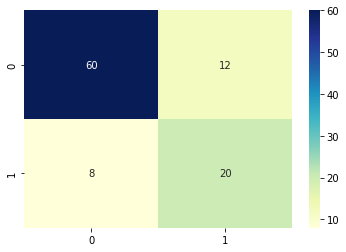

In [220]:
get_clf_eval(y_valid, y_pred_array>0.5)

In [210]:
# 필요한 train test코드를 다 작성하세요
##################################################################################################
# 필요한 라이브러리 불러오기
import torch 
import torch.nn as nn #
import torch.nn.functional as F # 각종 activation 함수
import torchvision # 이미지 관련 처리, Pretrained Model 관련된 Package 입니다. 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T # 이미지 처리 (Vison) 관련된 transformation이 정의 되어 있습니다.
import torch.optim as optim # pytorch 에서 정의한 수 많은 optimization function 들이 들어 있습니다.
from torch.utils import data

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
##################################################################################################
# # Data loader 불러오기
# def MNIST_DATA(root='./data',train =True,transforms=None ,download =True,batch_size = 32,num_worker = 1):
#     mnist_train = vision_dsets.MNIST(root = root,
#                                     train = True,
#                                     transform = T.ToTensor(),
#                                     download = True)
#     mnist_test = vision_dsets.MNIST(root = root,
#                                     train = False,
#                                     transform = T.ToTensor(),
#                                     download = True)
#     trainDataLoader = data.DataLoader(dataset = mnist_train, 
#                                       batch_size = batch_size, 
#                                       shuffle =True,
#                                       num_workers = 1) 
#     testDataLoader = data.DataLoader(dataset = mnist_test, 
#                                     batch_size = batch_size, 
#                                     shuffle = False, 
#                                     num_workers = 1) 
#     return mnist_train,mnist_test,trainDataLoader,testDataLoader

# trainDset,testDset,trainDataLoader,testDataLoader= MNIST_DATA(batch_size = 32)
##################################################################################################
# Trainaer 정의하기
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net  #학습시킬 모델
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch = 1):
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0): 
                inputs, labels = data
                self.optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
                if (i+1) % 500 == 0:
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                    running_loss = 0.0
        print('Finished Training')
        
    def test(self):
        self.net.eval()
        test_loss = 0
        correct = 0
        for inputs, labels in self.testloader:
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            test_loss /= len(self.testloader.dataset)
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))
##################################################################################################
# Network 만들어보기
# 가장 성능 좋고 학습 빨랐던 3-Layer Network (Conv+Pool+Fc) + ReLU + Adam + Grouph-Norm 기반으로 값 수정하며 진행
# channels / stride  / batch_size / epoch 변경 등 
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2)
        self.conv0_bn = nn.GroupNorm(num_groups = 4, num_channels = 8) 
        self.pool0 = nn.MaxPool2d(2)
        self.fc0 = nn.Linear(8*6*6, 40)
        self.fc1 = nn.Linear(40, 10)

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = x.view(x.shape[0], -1)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        return x
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
mnist_net = MNIST_Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

NameError: ignored

## 제출

In [231]:
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')

test파일 전처리

In [236]:
# step1 컬럼 생성 및 삭제

df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')

df_test['acc_ratio'] = df_test['acc_now_delinq'] / df_test['open_acc']
df_test = df_test.drop(columns=['delinq_amnt', 'out_prncp_inv', 'acc_now_delinq', 'funded_amnt_inv'])
df_test['my_multiple'] = df_test['int_rate']*df_test['dti']
df_test['my_multiple2'] = np.log(df_test['annual_inc']*df_test['fico_range_low'])
df_test['my_multiple4'] = df_test['int_rate']*df_test['funded_amnt']
df_test['my_multiple5'] = df_test['int_rate']*df_test['dti']/np.log(df_test['tot_cur_bal']*df_test['fico_range_low'])
df_test['my_multiple6'] = df_test['revol_util']/(df_test['revol_bal']+0.0000001)
df_test['my_multiple7'] = df_test['int_rate']*df_test['funded_amnt']/np.log(df_test['tot_cur_bal']*df_test['fico_range_low']+2)
df_test['my_multiple9'] = np.log(df_test['int_rate']*df_test['funded_amnt'])*df_test['dti']
df_test['my_multiple11'] = df_test['installment']/ df_test['annual_inc']
df_test.loc[df_test['collections_12_mths_ex_med'] <= 0.1, 'collections_12_mths_ex_med'] = 0   # 0번 추심 발생횟수
df_test.loc[df_test['collections_12_mths_ex_med']  > 0.1, 'collections_12_mths_ex_med'] = 1   # 1번 이상 추심 발생횟수
df_test['my_clf2'] = df.groupby([df.term1, df.emp_length12, df.home_ownership6, df.verification_status3, df.initial_list_status1, df.collections_12_mths_ex_med, df.initial_list_status2])['depvar'].transform('mean')

df_test.shape

(35816, 82)

In [237]:
# step2 상한선 설정

df_test2 = df_test.copy()
df_test2.loc[df_test2['tot_cur_bal']>1200000, 'tot_cur_bal'] = 1200000
df_test2.loc[df_test2['annual_inc']>480000, 'annual_inc'] = 480000
df_test2.loc[df_test2['revol_bal']>290000, 'revol_bal'] = 290000
df_test2.loc[df_test2['revol_util']>1.785, 'revol_util'] = 1.785
df_test2.loc[df_test2['total_rec_late_fee']>53, 'total_rec_late_fee'] = 53
df_test2.loc[df_test2['total_acc']>89, 'total_acc'] = 89
df_test2.loc[df_test2['open_acc']>41, 'open_acc'] = 41
df_test2.loc[df_test2['tot_coll_amt']>0.00008, 'tot_coll_amt'] = 0.00008

In [81]:
# step3 구간 나눠주기 (13개) // aux(auxiliary) = 보조의

test_auxtotal_rec_int = pd.cut(df_test2['total_rec_int'], 6) 
test_auxint_rate = pd.cut(df_test2['int_rate'], 15)      
test_auxinstallment = pd.cut(df_test2['installment'], 15)  
test_auxtot_cur_bal = pd.cut(df_test2['tot_cur_bal'], 10)  
test_auxdti = pd.cut(df_test2['dti'], 10)               
test_auxannual_inc = pd.cut(df_test2['annual_inc'], 10) 
test_auxrevol_bal = pd.cut(df_test2['revol_bal'], 10)    
test_auxrevol_util = pd.cut(df_test2['revol_util'], 10)  
test_auxtotal_acc = pd.cut(df_test2['total_acc'], 10)  
test_auxopen_acc = pd.cut(df_test2['open_acc'], 10)    
test_auxfico_range_low = pd.cut(df_test2['fico_range_low'], 10) 
test_auxfico_range_high = pd.cut(df_test2['fico_range_high'], 10) 
test_auxfunded_amnt = pd.cut(df_test2['funded_amnt'], 10)

# aux_list 13개
test_aux_dict = {'total_rec_int':test_auxtotal_rec_int, 'int_rate':test_auxint_rate, 'installment':test_auxinstallment, 
            'tot_cur_bal':test_auxtot_cur_bal, 'dti':test_auxdti, 'annual_inc':test_auxannual_inc, 'revol_bal':test_auxrevol_bal, 'revol_util':test_auxrevol_util,
            'total_acc':test_auxtotal_acc, 'open_acc': test_auxopen_acc, 'fico_range_low':test_auxfico_range_low,
            'fico_range_high':test_auxfico_range_high, 'funded_amnt':test_auxfunded_amnt}

In [82]:
# step4 컬럼에 구간 나눈대로 라벨링 해주기

df_test3 = df_test2.copy()

# Label넣어줄 리스트 생성
test_col_for_label = ['total_rec_int', 'int_rate',  'installment', 'tot_cur_bal','dti', 'annual_inc', 'revol_bal', 
                       'revol_util', 'total_acc', 'open_acc', 'fico_range_low', 'fico_range_high', 'funded_amnt']

# 라벨화 작업 진행
for name in test_col_for_label:
    df_test3[name] = LabelEncoder().fit_transform(test_aux_dict[name])

In [83]:
# step5 수동으로 구간 작업한 것 넣어주기

# 코드 순서주의!!!!
df_test3.loc[(df_test3['total_rec_late_fee'] > 1.7) & (df_test3['total_rec_late_fee'] <= 12), 'total_rec_late_fee'] = 4
df_test3.loc[df_test3['total_rec_late_fee']  > 12, 'total_rec_late_fee'] = 5
df_test3.loc[(df_test3['total_rec_late_fee'] > 0.06) & (df_test3['total_rec_late_fee'] <= 1.7), 'total_rec_late_fee'] = 3
df_test3.loc[(df_test3['total_rec_late_fee'] > 0.002) & (df_test3['total_rec_late_fee'] <= 0.06), 'total_rec_late_fee'] = 2
df_test3.loc[(df_test3['total_rec_late_fee'] > 0.000001) & (df_test3['total_rec_late_fee'] <= 0.002), 'total_rec_late_fee'] = 1
df_test3.loc[ df_test3['total_rec_late_fee'] <= 0.000001, 'total_rec_late_fee'] = 0

df_test3.loc[df_test3['tot_coll_amt']  > 0.02, 'tot_coll_amt'] = 2
df_test3.loc[(df_test3['tot_coll_amt'] > 0.00001) & (df_proc_2['tot_coll_amt'] <= 0.02), 'tot_coll_amt'] = 1
df_test3.loc[df_test3['tot_coll_amt'] <= 0.00001, 'tot_coll_amt'] = 0

df_test3.loc[df_test3['delinq_2yrs'] <= 4, 'delinq_2yrs'] = 0                                     #4년이하 2:1 비율
df_test3.loc[(df_test3['delinq_2yrs'] > 4) & (df_proc_2['delinq_2yrs'] <= 10), 'delinq_2yrs'] = 1 #5~8년 채무불이행비율 증가
df_test3.loc[df_test3['delinq_2yrs']  > 10, 'delinq_2yrs'] = 2                                    #9년 이상

df_test3.loc[df_test3['collections_12_mths_ex_med'] <= 0.1, 'collections_12_mths_ex_med'] = 0     # 0번 추심 발생횟수
df_test3.loc[df_test3['collections_12_mths_ex_med']  > 0.1, 'collections_12_mths_ex_med'] = 1     # 1번 이상

df_test3.loc[df_test3['tax_liens'] <= 0.1, 'tax_liens'] = 0                                   #0번 세금 저당권 2:1 비율
df_test3.loc[(df_test3['tax_liens'] > 0.1) & (df_proc_2['tax_liens'] <= 1.5), 'tax_liens'] = 1 #1번 채무불이행비율 증가
df_test3.loc[df_test3['tax_liens']  > 1.5, 'tax_liens'] = 2 

df_test3.loc[df_test3['pub_rec'] <= 0.1, 'pub_rec'] = 0                                   #파산 횟수 0번
df_test3.loc[(df_test3['pub_rec'] > 0.1) & (df_proc_2['pub_rec'] <= 4.2), 'pub_rec'] = 1  #1~4번
df_test3.loc[df_test3['pub_rec']  > 4.2, 'pub_rec'] = 2                                   #5회 이상

# 코드 넣는 순서 중요!! 거꾸로 하면 0.35 이상은 다 5로 바꿔버림
df_test3.loc[df_test3['acc_ratio']  > 0.35, 'acc_ratio'] = 5
df_test3.loc[(df_test3['acc_ratio'] > 0.15) & (df_test3['acc_ratio'] <= 0.35), 'acc_ratio'] = 4
df_test3.loc[(df_test3['acc_ratio'] > 0.05) & (df_test3['acc_ratio'] <= 0.15), 'acc_ratio'] = 3
df_test3.loc[(df_test3['acc_ratio'] > 0.035) & (df_test3['acc_ratio'] <= 0.05), 'acc_ratio'] = 2
df_test3.loc[(df_test3['acc_ratio'] > 0.0001) & (df_test3['acc_ratio'] <= 0.035), 'acc_ratio'] = 1
df_test3.loc[df_test3['acc_ratio'] <= 0.0001, 'acc_ratio'] = 0 


In [84]:
# step6 원핫인코딩 진행

# test는 ID항목 먼저 추가로 제거
df_test3 = df_test3.drop('ID', axis=1)
# 더미화를 위한 칼럼
test_col_for_dummies = list(df_test3.columns)
test_col_for_dummies.remove('my_multiple')
test_col_for_dummies.remove('my_multiple2')
test_col_for_dummies.remove('my_multiple4')
test_col_for_dummies.remove('my_multiple5')
test_col_for_dummies.remove('my_multiple6')
test_col_for_dummies.remove('my_multiple7')
test_col_for_dummies.remove('my_multiple9')
test_col_for_dummies.remove('my_multiple11')
test_col_for_dummies.remove('my_clf2')
test_col_for_dummies.remove('out_prncp')


# df_test4 -> 원핫인코딩으로 바꿔준 DataFrame
df_test4 = pd.get_dummies(df_test3, columns=test_col_for_dummies)

In [223]:
df_test2.shape

(35816, 82)

In [61]:
print(list(df_test4))

['out_prncp', 'my_multiple', 'my_multiple2', 'my_multiple4', 'my_multiple5', 'my_multiple6', 'my_multiple7', 'my_multiple9', 'my_multiple11', 'my_clf2', 'int_rate_0', 'int_rate_1', 'int_rate_2', 'int_rate_3', 'int_rate_4', 'int_rate_5', 'int_rate_6', 'int_rate_7', 'int_rate_8', 'int_rate_9', 'int_rate_10', 'int_rate_11', 'int_rate_12', 'int_rate_13', 'int_rate_14', 'annual_inc_0', 'annual_inc_1', 'annual_inc_2', 'annual_inc_3', 'annual_inc_4', 'annual_inc_5', 'annual_inc_6', 'annual_inc_7', 'annual_inc_8', 'annual_inc_9', 'dti_0', 'dti_1', 'dti_2', 'dti_3', 'dti_4', 'dti_5', 'dti_6', 'dti_7', 'dti_8', 'dti_9', 'delinq_2yrs_0', 'delinq_2yrs_1', 'inq_last_6mths_0', 'inq_last_6mths_1', 'inq_last_6mths_2', 'inq_last_6mths_3', 'inq_last_6mths_4', 'inq_last_6mths_5', 'inq_last_6mths_6', 'pub_rec_0', 'pub_rec_1', 'revol_bal_0', 'revol_bal_1', 'revol_bal_2', 'revol_bal_3', 'revol_bal_4', 'revol_bal_5', 'revol_bal_6', 'revol_bal_7', 'revol_bal_8', 'revol_bal_9', 'total_acc_0', 'total_acc_1', 't

In [238]:
X_test = df_test2.drop('ID', axis=1)
X_test_sc = StandardScaler().fit_transform(X_test)
test_data = TestData(torch.FloatTensor(X_test_sc))
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [239]:
X_test_sc.shape

(35816, 81)

In [241]:
y_pred_array = np.array([])
# y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        # y_pred_tag = torch.round(y_valid_pred)
        # y_pred_array.append(y_valid_pred.cpu().numpy())
        y_pred_array = np.append(y_pred_array, y_test_pred.cpu().numpy())

In [242]:
y_pred_array

array([0.71960205, 0.57200307, 0.61626732, ..., 0.01878296, 0.15485843,
       0.24399322])

In [246]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/competition_1st/sample_submission.csv')

# prediction 수행

submit['answer'] = y_pred_array>0.4
change = {True:1, False:0}
submit.answer = submit.answer.map(change)
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/competition_1st/submission_22.csv', index=False)

In [245]:
submit

,ID,answer
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
35811,35811,0
35812,35812,0
35813,35813,0
35814,35814,0


In [ ]:
submit.head()

,ID,answer
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
